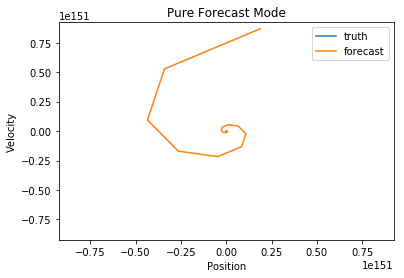

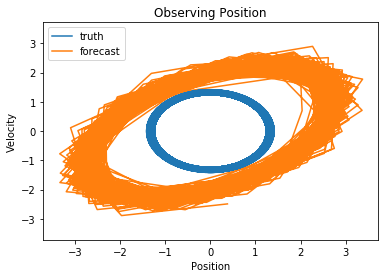

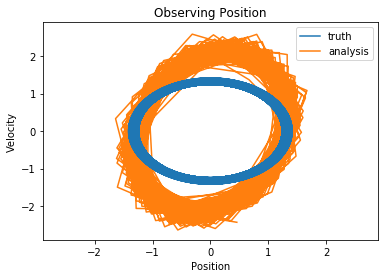

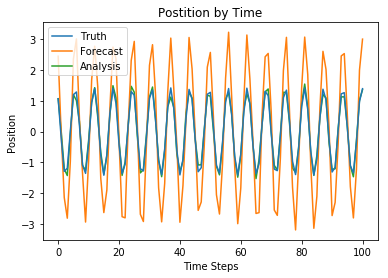

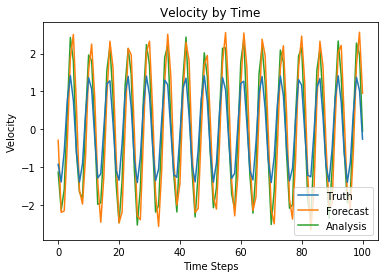

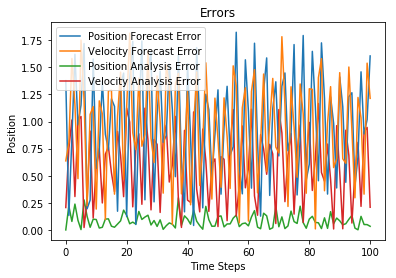

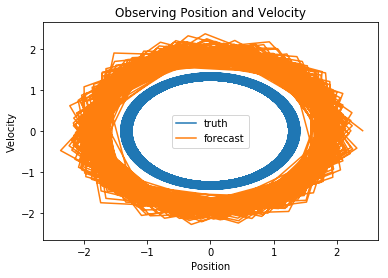

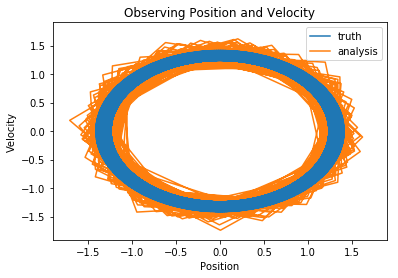

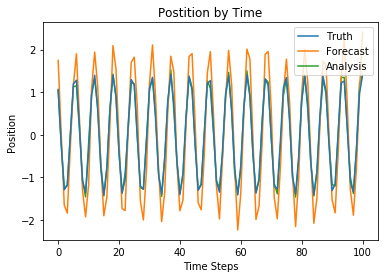

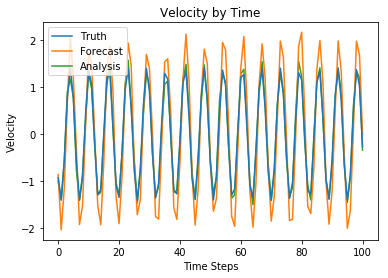

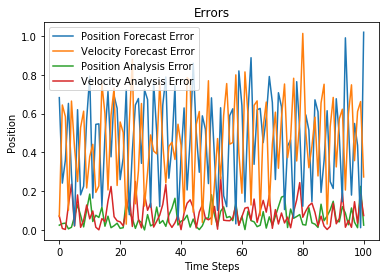

SystemExit: 0

In [170]:
#!/usr/bin/env python3
# coding: utf-8

###################################################
# Script for Kalman filter                        #
# 1) Pure Forecast Mode                           #
# 2) Observing Position and Velocity              #
# 3) Observing Position Only                      #
#                                                 #
# Author: Merlin Carson                           #
# Date: Nov-23-2019                               #
###################################################

import sys
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin

def plot_data(truth, data, label=None, title=None):
    axes = plt.gca()

    plt.title(title)
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.plot(truth[2:, 0], truth[2:, 1], label='truth', zorder=1)
    plt.plot(data[2:, 0], data[2:, 1], label=label, zorder=0)
    xmin, xmax = axes.get_xlim()
    ymin, ymax = axes.get_ylim()
    x_max = max(abs(xmin), xmax)
    y_max = max(abs(ymin), ymax)
    limit = max(x_max, y_max)
    axes.set_xlim(-limit, limit)
    axes.set_ylim(-limit, limit)
    plt.legend()
    
    plt.show()

def plot_elements(truth, forecast, analysis):
    plt.figure()
    plt.title('Postition by Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Position')
    plt.plot(truth[900:,0], label='Truth', zorder=2)
    plt.plot(forecast[900:,0], label='Forecast', zorder=1)
    plt.plot(analysis[900:,0], label='Analysis', zorder=0)
    plt.legend()
    
    plt.figure()
    plt.title('Velocity by Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Velocity')
    plt.plot(truth[900:,1], label='Truth', zorder=2)
    plt.plot(forecast[900:,1], label='Forecast', zorder=1)
    plt.plot(analysis[900:,1], label='Analysis', zorder=0)
    plt.legend()
   
    plt.figure()
    plt.title('Errors')
    plt.xlabel('Time Steps')
    plt.ylabel('Position')
    plt.plot(np.abs(forecast[900:,0] - truth[900:,0]), label='Position Forecast Error', zorder=2)
    plt.plot(np.abs(forecast[900:,1] - truth[900:,1]), label='Velocity Forecast Error', zorder=2)
    plt.plot(np.abs(analysis[900:,0] - truth[900:,0]), label='Position Analysis Error', zorder=0)
    plt.plot(np.abs(analysis[900:,1] - truth[900:,1]), label='Velocity Analysis Error', zorder=0)
    plt.legend()

    plt.show()
    
def pos(t, x0, v0):
    return v0 * sin(t) + x0 * cos(t)
    
def velocity(t, x0, v0):
    return v0 * cos(t) - x0 * sin(t)

def observation(x_t, H, obs_error):
    return H@x_t + obs_error

def model(X, M, model_error):
    return M@X + model_error

def forecast(x_a, M):
    return M@x_a 

def cov_forecast(M, P_a, Q):
    return M@P_a@M.T + Q

def gen_observation(H, x_t, obs_error):
    return H@x_t + obs_error

def kalman_gain(P_f, H, R):
    return P_f@H.T @ np.linalg.inv(H@P_f@H.T + R) 

def analize(x_f, K, y, H):
    return x_f + K@(y - H@x_f)

def cov_analysis(K, H, P_f):
    return (np.eye(K.shape[0]) - K@H)@P_f

def kalman(time_steps, num_observations, forecast_only=False):
    
    # setup error
    prior_error = np.random.normal(loc=0, scale=1, size=(2,1))

    # setup initial vals
    t = 0
    x0 = v0 = 1
    X0 = np.array([[pos(t, x0, v0)],[velocity(t, x0, v0)]])
    x_f = X0 + prior_error
    x_a = X0 + prior_error

    # observation info
    if num_observations == 1:    
        obs_error = lambda stddev: np.random.normal(loc=0, scale=stddev, size=(1,1))
        H = np.array([[1,0]]) 
        title = 'Observing Position'
    else:
        obs_error = lambda stddev: np.random.normal(loc=0, scale=stddev, size=(2,1))
        H = np.array([[1,0], [0,1]])
        title = 'Observing Position and Velocity'

    # setup matricies
    M = np.array([[1,1], [-1,1]])
    P_a = Q = np.eye(M.shape[0])
    R = 0.1**2 * np.eye(H.shape[0])
  
    forecasts = [x_f]
    analysis = [x_a]
    truths = [X0]
    
    for i in range(time_steps):
        if forecast_only is True:
            x_f = forecast(x_f, M)
            forecasts.append(x_f)
            x_t = np.array([[pos(i+1,x0,v0)], [velocity(i+1,x0,v0)]])
            truths.append(x_t)
            continue

        # forecast
        x_f = forecast(x_a, M)
        forecasts.append(x_f)
        P_f = cov_forecast(M, P_a, Q)

        # generate observation
        x_t = np.array([[pos(i+1,x0,v0)], [velocity(i+1,x0,v0)]])
        truths.append(x_t)
        y = gen_observation(H, x_t, obs_error(0.1))
        
        # calc Kalman gain
        K = kalman_gain(P_f, H, R)

        # analysis step
        x_a = analize(x_f, K, y, H)
        analysis.append(x_a)

        P_a = cov_analysis(K, H, P_f)

    
    if forecast_only:
        plot(np.array(truths), np.array(forecasts), label='forecast', title='Pure Forecast Mode')
        return
        
    plot_data(np.array(truths), np.array(forecasts), label='forecast', title=title)
    plot_data(np.array(truths), np.array(analysis), label='analysis', title=title)
    
    plot_elements(np.array(truths), np.array(forecasts), np.array(analysis))
    

def main():
    time_steps = 1000
    
    # forecast only
    num_observations = 2
    kalman(time_steps, num_observations, forecast_only=True)
    # positional observation only
    num_observations = 1
    kalman(time_steps, num_observations)
    
    # position and velocity observations
    num_observations = 2
    kalman(time_steps, num_observations)

    return 0

if __name__ == '__main__':
    sys.exit(main())